This dataset shows the NYC taxi demand from 2014–07–01 to 2015–01–31 with an observation every half hour. In this period 5 anomalies are present, in term of deviation from a normal behavior. They occur respectively during the NYC marathon, Thanksgiving, Christmas, New Years day, and a snow storm.
goal is to detect the anomalies in the best way possible.

In [1]:
import keras
from keras import optimizers
from keras import losses
from keras.models import Sequential, Model
from keras.layers import Dense, Input, Dropout, Embedding, LSTM, Bidirectional,  SpatialDropout1D, Conv1D
from keras.optimizers import RMSprop, Adam, Nadam
from keras.preprocessing import sequence
from keras.callbacks import TensorBoard

import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_auc_score
from sklearn.preprocessing import MinMaxScaler

import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib
import math
from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline

import tensorflow 
import sys
print("Python: ", sys.version)

print("pandas: ", pd.__version__)
print("numpy: ", np.__version__)
print("seaborn: ", sns.__version__)
print("matplotlib: ", matplotlib.__version__)
print("sklearn: ", sklearn.__version__)
print("Keras: ", keras.__version__)
print("Tensorflow: ", tensorflow.__version__)


C:\Users\Shumpu\Anaconda2\envs\p36\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


Python:  3.6.5 |Anaconda, Inc.| (default, Mar 29 2018, 13:32:41) [MSC v.1900 64 bit (AMD64)]
pandas:  0.24.2
numpy:  1.16.3
seaborn:  0.8.1
matplotlib:  2.2.2
sklearn:  0.19.1
Keras:  2.0.8
Tensorflow:  1.10.0


In [2]:
class Visualization:
    labels = ["Normal", "Anomaly"]

    def draw_anomaly(self, y, error, threshold):
        groupsDF = pd.DataFrame({'error': error,
                                 'true': y}).groupby('true')

        figure, axes = plt.subplots(figsize=(12, 8))

        for name, group in groupsDF:
            x = group.index.values
            y = group.error
            axes.plot(x, y, marker='x' if name == 1 else 'o', linestyle='',
                    color='r' if name == 1 else 'g', label="Anomaly" if name == 1 else "Normal")

        axes.hlines(threshold, axes.get_xlim()[0], axes.get_xlim()[1], colors="b", zorder=100, label='Threshold')
        axes.legend()
        
        plt.title("Anomalies")
        plt.ylabel("Error")
        plt.xlabel("Data")
        plt.show()

    def draw_error(self, error, threshold):
        plt.figure(figsize=(10, 8))
        plt.plot(error, marker='o', ms=3.5, linestyle='',
                 label='Point')

        plt.hlines(threshold, xmin=0, xmax=len(error)-1, colors="r", zorder=100, label='Threshold')
        plt.legend()
        plt.title("Reconstruction error")
        plt.ylabel("Error")
        plt.xlabel("Data")
        plt.show()

In [3]:

tensorlogs = ["art_daily_no_noise", #0
              "art_daily_nojump", #1
              "art_daily_jumpsdown",#2 
              "art_daily_perfect_square_wave", #3 
              "art_increase_spike_density",  #4
              "art_load_balancer_spikes",  #5
              "ambient_temperature_system_failure", #6 
              "nyc_taxi",  #7
              "ec2_cpu_utilization", #8
              "rds_cpu_utilization"] #9 

dataFilePaths = ['data/art_daily_no_noise.csv',
                 'data/art_daily_nojump.csv',
                 'data/art_daily_jumpsdown.csv',
                 'data/art_daily_perfect_square_wave.csv',
                 'data/art_increase_spike_density.csv',
                 'data/art_load_balancer_spikes.csv',
                 'data/ambient_temperature_system_failure.csv',
                 'datasets/sandp500/individual_stocks_5yr/individual_stocks_5yr/BAC_data.csv',
                 'data/ec2_cpu_utilization.csv',
                 'data/rds_cpu_utilization.csv']




In [4]:
i = 7

tensorlog = tensorlogs[i]
dataFilePath = dataFilePaths[i]
print("tensorlog: ", tensorlog)
print("dataFilePath: ", dataFilePath)

tensorlog:  nyc_taxi
dataFilePath:  datasets/sandp500/individual_stocks_5yr/individual_stocks_5yr/BAC_data.csv


In [96]:
#date, open, high, low, close, volume, name

df = pd.read_csv(filepath_or_buffer=dataFilePath, header=0, sep=',')
print('Shape:' , df.shape[0])
print('Head:')
df.head()

Shape: 1259
Head:


,date,open,high,low,close,volume,Name
0,2013-02-08,11.86,11.90,11.72,11.760,145217221,BAC
1,2013-02-11,11.73,11.90,11.67,11.860,103499848,BAC
2,2013-02-12,11.87,12.34,11.78,12.245,231771561,BAC
3,2013-02-13,12.35,12.42,12.05,12.170,192478919,BAC
4,2013-02-14,12.09,12.27,12.07,12.130,143901737,BAC


In [91]:
df.tail()

,date,open,high,low,close,volume,Name
1254,2018-02-01,32.00,32.50,31.96,32.50,62367448,BAC
1255,2018-02-02,32.44,32.67,31.86,31.95,96971924,BAC
1256,2018-02-05,31.12,31.98,29.15,30.26,155908256,BAC
1257,2018-02-06,29.41,31.29,29.30,31.20,165878399,BAC
1258,2018-02-07,31.12,31.74,30.86,31.25,101180515,BAC


Text(0.5,1,'Time Series of value by date time')

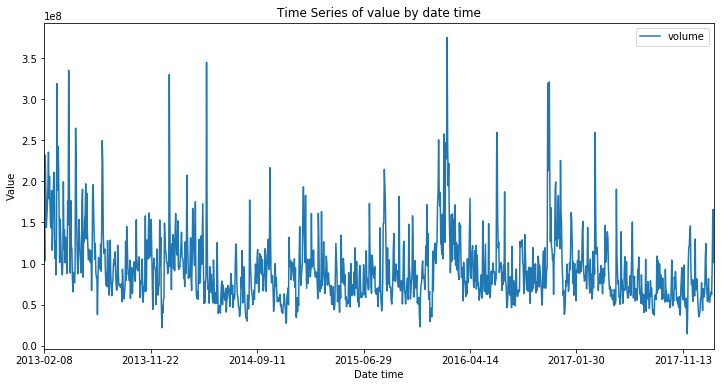

In [93]:
# df2 = df[(df.Datetime > '2014-09-01') & (df.Datetime < '2014-11-30')]
df.plot(x='date', y='volume', figsize=(12,6))
plt.xlabel('Date time')
plt.ylabel('Value')
plt.title('Time Series of value by date time')

(453, 8)


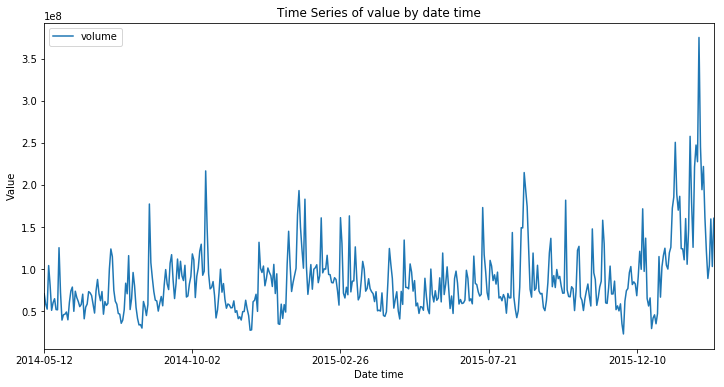

In [190]:
df2 = df[(df.Datetime > '2013-02-08') & (df.Datetime < '2016-02-28')]
df2.plot(x='date', y='volume', figsize=(12,6))
plt.xlabel('Date time')
plt.ylabel('Value')
plt.title('Time Series of value by date time')
print(df2.shape)

In [283]:
df['Datetime'] = pd.to_datetime(df['date'])
# df['dayofweek'] = df['Datetime'].dt.dayofweek
# df['month'] = df['Datetime'].dt.month
# df['hour'] = df['Datetime'].dt.hour
#df['hour'] = [1 if (ele >= 8 and ele < 20) else 0 for ele in df["hour"]]

#2013-02-08 to 2018-02-07
df = df[(df.Datetime > '2013-02-08') & (df.Datetime < '2018-02-28')]
df = df.reset_index(drop=True)
print(df.shape)
print(df.head(5))
training_points = 500

(944, 8)
         date   open   high      low  close     volume   Datetime  \
0  2014-05-12  14.79  15.10  14.7900  15.07   70669928 2014-05-12   
1  2014-05-13  15.04  15.10  14.9400  15.03   58469055 2014-05-13   
2  2014-05-14  14.99  15.02  14.8100  14.84   52431852 2014-05-14   
3  2014-05-15  14.82  14.83  14.3900  14.55  104192968 2014-05-15   
4  2014-05-16  14.51  14.54  14.3675  14.51   80476129 2014-05-16   

   scaled_value  
0      0.156303  
1      0.122488  
2      0.105756  
3      0.249212  
4      0.183481  


(944, 8)


Text(0.5,1,'Time Series of value by date time')

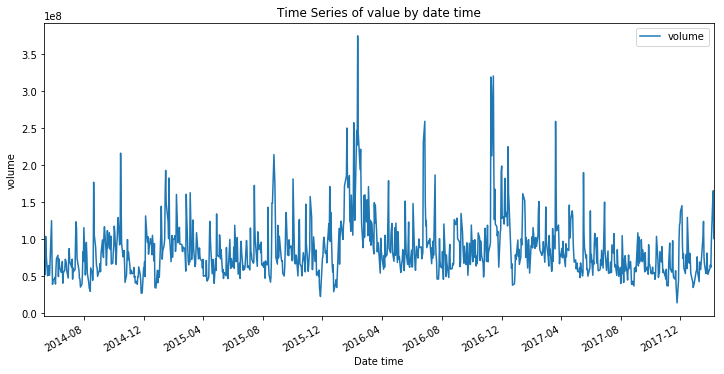

In [284]:
print(df.shape)
df.plot(x='Datetime', y='volume', figsize=(12,6))
plt.xlabel('Date time')
plt.ylabel('volume')
plt.title('Time Series of value by date time')

C:\Users\Shumpu\Anaconda2\envs\p36\lib\site-packages\numpy\lib\function_base.py:2522: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)
C:\Users\Shumpu\Anaconda2\envs\p36\lib\site-packages\numpy\lib\function_base.py:2451: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)


Text(0,0.5,'correlation coeff')

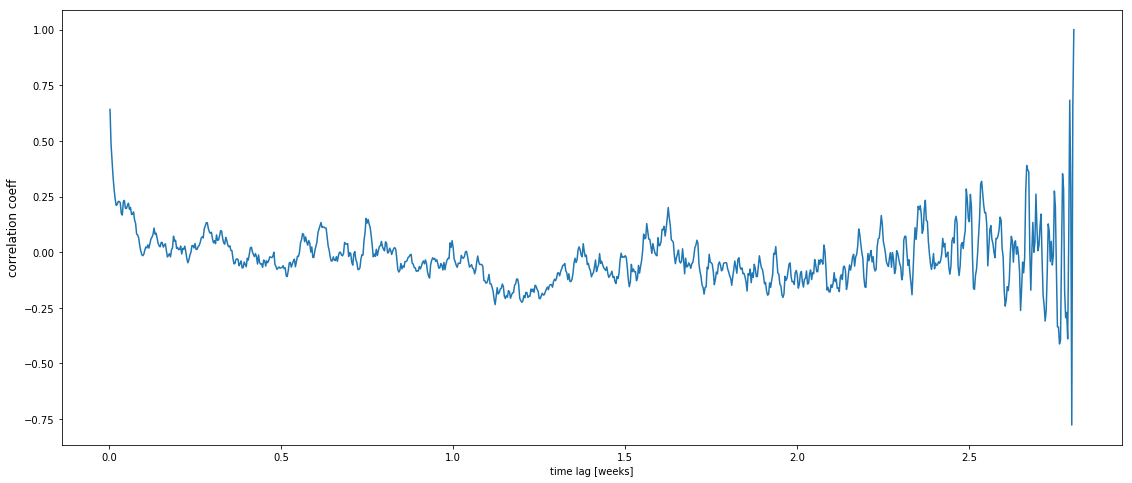

In [285]:
timeLags = np.arange(1,10*48*7)
autoCorr = [df.volume.autocorr(lag=dt) for dt in timeLags]
plt.figure(figsize=(19,8))
plt.plot(1.0/(48*7)*timeLags, autoCorr)
plt.xlabel('time lag [weeks]')
plt.ylabel('correlation coeff', fontsize=12)

(944, 8)


Text(0.5,1,'Time Series of value by date time')

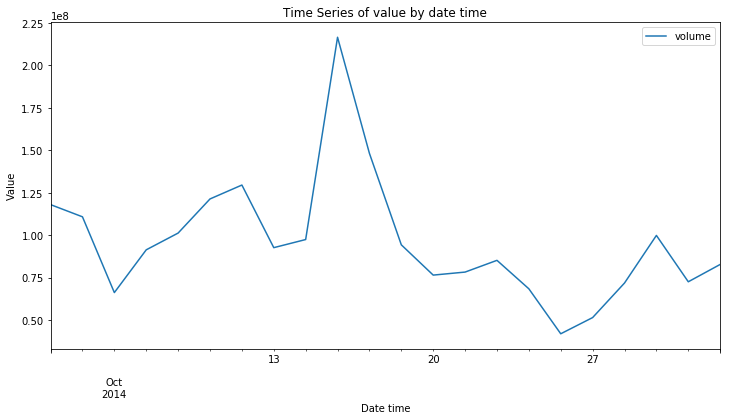

In [286]:
df2 = df[(df.Datetime > '2014-10-01') & (df.Datetime < '2014-11-01')]
print(df.shape)
df2.plot(x='Datetime', y='volume', figsize=(12,6))
plt.xlabel('Date time')
plt.ylabel('Value')
plt.title('Time Series of value by date time')

Text(0.5,1,'Time Series of value by date time')

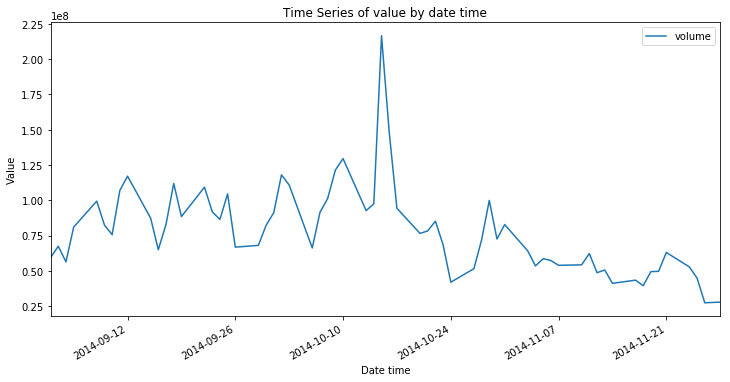

In [287]:
df2 = df[(df.Datetime > '2014-09-01') & (df.Datetime < '2014-11-30')]
df2.plot(x='Datetime', y='volume', figsize=(12,6))
plt.xlabel('Date time')
plt.ylabel('Value')
plt.title('Time Series of value by date time')

In [288]:
df.volume.describe()

count    9.440000e+02
mean     8.704662e+07
std      3.973868e+07
min      1.427357e+07
25%      6.175713e+07
50%      7.761241e+07
75%      1.008785e+08
max      3.750886e+08
Name: volume, dtype: float64

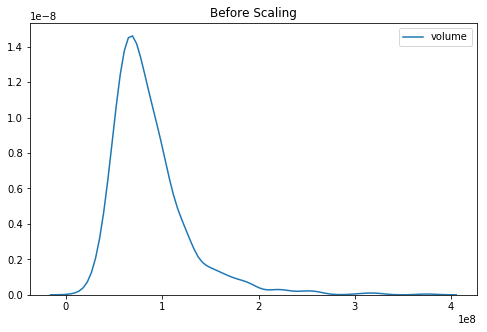

In [289]:
fig, (ax1) = plt.subplots(ncols=1, figsize=(8, 5))
ax1.set_title('Before Scaling')
sns.kdeplot(df['volume'], ax=ax1)

In [290]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range = (0, 1))
df['scaled_value'] = pd.DataFrame(scaler.fit_transform(pd.DataFrame(df['volume'])),columns=['volume'])
print('Shape:' , df.shape[0])

df.head(5)

Shape: 944


,date,open,high,low,close,volume,Datetime,scaled_value
0,2014-05-12,14.79,15.10,14.7900,15.07,70669928,2014-05-12,0.156303
1,2014-05-13,15.04,15.10,14.9400,15.03,58469055,2014-05-13,0.122488
2,2014-05-14,14.99,15.02,14.8100,14.84,52431852,2014-05-14,0.105756
3,2014-05-15,14.82,14.83,14.3900,14.55,104192968,2014-05-15,0.249212
4,2014-05-16,14.51,14.54,14.3675,14.51,80476129,2014-05-16,0.183481


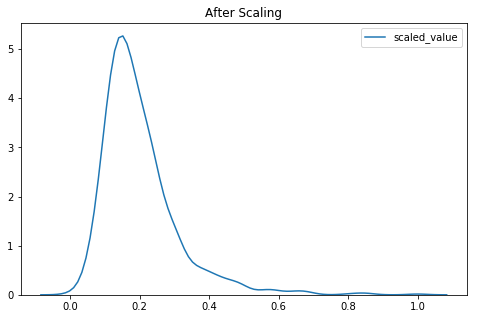

In [291]:
fig, (ax1) = plt.subplots(ncols=1, figsize=(8, 5))
ax1.set_title('After Scaling')
sns.kdeplot(df['scaled_value'], ax=ax1)

In [292]:
df = df.drop("Name", axis=1)
df.head(5)

KeyError: "['Name'] not found in axis"

In [294]:
# split a univariate sequence into samples
def split_sequence(sequence, n_steps_in, n_steps_out):
    X, y = list(), list()
    for i in range(len(sequence)):
        # find the end of this pattern
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out
        # check if we are beyond the sequence
        if out_end_ix > len(sequence):
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix: out_end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

# choose a number of time steps
n_steps = 64
n_features =5
n_steps_out =1
# split into samples
rawsequence = np.array(df[['scaled_value', 'open', 'high', 'low', 'close']].values)
#rawsequence = np.array(df['scaled_value'])
trainsequence = rawsequence[0:training_points]
testsequence = rawsequence[training_points:]

X_train, y_train = split_sequence(trainsequence, n_steps, n_steps_out)
X_test, y_test = split_sequence(testsequence, n_steps, n_steps_out)
# summarize the data
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

#print(rawsequence[0:12])
for i in range(2):
	print(X_train[i][0:4], y_train[i])

(436, 64, 5) (436, 1, 5)
(380, 64, 5) (380, 1, 5)
[[ 0.15630266 14.79       15.1        14.79       15.07      ]
 [ 0.1224879  15.04       15.1        14.94       15.03      ]
 [ 0.10575578 14.99       15.02       14.81       14.84      ]
 [ 0.24921186 14.82       14.83       14.39       14.55      ]] [[ 0.05376931 15.18       15.3        15.15       15.21      ]]
[[ 0.1224879  15.04       15.1        14.94       15.03      ]
 [ 0.10575578 14.99       15.02       14.81       14.84      ]
 [ 0.24921186 14.82       14.83       14.39       14.55      ]
 [ 0.18348057 14.51       14.54       14.3675     14.51      ]] [[ 0.05483572 15.25       15.29       15.2        15.25      ]]


In [295]:
print(X_train.shape)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], n_features))
print(X_train.shape)

(436, 64, 5)
(436, 64, 5)


In [296]:
print(y_train.shape)
# y_train = y_train.reshape(y_train.shape[0],y_train.shape[1],n_features)
y_train = y_train.reshape(y_train.shape[0], n_features)
print(y_train.shape)

(436, 1, 5)
(436, 5)


In [297]:
from keras.layers import regularizers, Flatten, MaxPooling1D, UpSampling1D



input_layer = Input (shape = (n_steps, n_features))

#Series of temporal convolutional layers with dilations increasing by powers of 2.
conv_1 = Conv1D(filters=int(n_steps), kernel_size=2, dilation_rate=1,
                padding='causal', strides=1,input_shape=(n_steps, n_features),
                kernel_regularizer=regularizers.l2(0.01),
                activation='relu')(input_layer)

#Dropout layer after each 1D-convolutional layer
pool_1 = MaxPooling1D(pool_size=2, strides=2)(conv_1)

conv_2 = Conv1D(filters=int(n_steps/ 2), kernel_size=2, dilation_rate=2,
                padding='causal',strides=1, kernel_regularizer=regularizers.l2(0.01),
                activation='relu')(pool_1)

pool_2 = MaxPooling1D(pool_size=2, strides=3)(conv_2)

conv_3 = Conv1D(filters=int(n_steps / 3), kernel_size=2, dilation_rate=4,
                padding='causal', strides=1,kernel_regularizer=regularizers.l2(0.01),
                activation='relu')(pool_2)

pool_3 = MaxPooling1D(pool_size=1, strides=1)(conv_3)

encoder = Dense(int(n_steps / 6), activation='relu')(pool_3)


upsample_1 = UpSampling1D(size=3)(encoder)

conv_4 = Conv1D(filters=int(n_steps/3), kernel_size=2, dilation_rate=4,
                padding='causal',strides=1, kernel_regularizer=regularizers.l2(0.01),
                activation='relu')(upsample_1)

upsample_2 = UpSampling1D(size=2)(conv_4)

conv_5 = Conv1D(filters=int(n_steps/2), kernel_size=2, dilation_rate=2,
                padding='causal', strides=1,kernel_regularizer=regularizers.l2(0.05),
                activation='relu')(upsample_2)

upsample_3 = UpSampling1D(size=1)(conv_5)

conv_6 = Conv1D(filters=int(n_steps), kernel_size=2, dilation_rate=1,
                padding='causal', strides=1,kernel_regularizer=regularizers.l2(0.05),
                activation='relu')(upsample_3)

upsample_4 = UpSampling1D(size=1)(conv_6)

flat = Flatten()(upsample_4)

output_layer = Dense(int(n_features))(flat)



# input_layer = Input (shape = (n_steps, n_features))
# conv_1 = Conv1D(filters=256, kernel_size=1, dilation_rate=1,
#                 padding='causal', strides=1,input_shape=(n_steps, n_features),
#                 kernel_regularizer=regularizers.l2(0.01),
#                 activation='relu')(input_layer)

# drop_1 = SpatialDropout1D(0.3)(conv_1)

# conv_2 = Conv1D(filters=128, kernel_size=1, dilation_rate=1,
#                 padding='causal',strides=1, kernel_regularizer=regularizers.l2(0.01),
#                 activation='relu')(drop_1)

# drop_2 = SpatialDropout1D(0.3)(conv_2)

# conv_3 = Conv1D(filters=64, kernel_size=1, dilation_rate=1,
#                 padding='causal', strides=1,kernel_regularizer=regularizers.l2(0.01),
#                 activation='relu')(drop_2)

# drop_3 = SpatialDropout1D(0.3)(conv_3)

# conv_4 = Conv1D(filters=32, kernel_size=1, dilation_rate=1,
#                 padding='causal', strides=1,kernel_regularizer=regularizers.l2(0.05),
#                 activation='relu')(drop_3)

# flattened = Flatten()(conv_4)
# dense = Dense(32)(flattened)
# out = Dense(4)(dense)

model = Model(input_layer, output_layer)
model.compile(optimizer=keras.optimizers.Adam(lr=0.002), loss='mse', metrics=['mse', 'accuracy'])
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        (None, 64, 5)             0         
_________________________________________________________________
conv1d_55 (Conv1D)           (None, 64, 64)            704       
_________________________________________________________________
max_pooling1d_28 (MaxPooling (None, 32, 64)            0         
_________________________________________________________________
conv1d_56 (Conv1D)           (None, 32, 32)            4128      
_________________________________________________________________
max_pooling1d_29 (MaxPooling (None, 11, 32)            0         
_________________________________________________________________
conv1d_57 (Conv1D)           (None, 11, 21)            1365      
_________________________________________________________________
max_pooling1d_30 (MaxPooling (None, 11, 21)            0         
__________

In [298]:
batch_size=48
epochs=1000

model.fit(x=X_train, y=y_train,
                       batch_size=batch_size, epochs=epochs,
                       verbose=1, 
                       callbacks=[TensorBoard(log_dir='/logs/{0}'.format(tensorlog))])

Epoch 1/1000
436/436 [==============================] - 1s - loss: 81.4987 - mean_squared_error: 77.3896 - acc: 0.7523         
Epoch 2/1000
436/436 [==============================] - 0s - loss: 15.2325 - mean_squared_error: 11.5419 - acc: 0.0092         
Epoch 3/1000
436/436 [==============================] - 0s - loss: 7.0627 - mean_squared_error: 3.7212 - acc: 0.9794     
Epoch 4/1000
436/436 [==============================] - 0s - loss: 5.9298 - mean_squared_error: 2.8620 - acc: 0.1972     
Epoch 5/1000
436/436 [==============================] - 0s - loss: 4.9815 - mean_squared_error: 2.1275 - acc: 0.8716     
Epoch 6/1000
436/436 [==============================] - 0s - loss: 4.4493 - mean_squared_error: 1.7636 - acc: 0.9128     
Epoch 7/1000
436/436 [==============================] - 0s - loss: 4.5655 - mean_squared_error: 2.0137 - acc: 0.9771     
Epoch 8/1000
436/436 [==============================] - 0s - loss: 4.2810 - mean_squared_error: 1.8368 - acc: 0.9794     
Epoch 9/1000

436/436 [==============================] - 0s - loss: 1.5773 - mean_squared_error: 0.4374 - acc: 0.9794     
Epoch 68/1000
436/436 [==============================] - 0s - loss: 1.4931 - mean_squared_error: 0.3619 - acc: 0.9679     
Epoch 69/1000
436/436 [==============================] - 0s - loss: 1.6726 - mean_squared_error: 0.5501 - acc: 0.9679     
Epoch 70/1000
436/436 [==============================] - 0s - loss: 1.4854 - mean_squared_error: 0.3711 - acc: 0.9748     
Epoch 71/1000
436/436 [==============================] - 0s - loss: 1.4877 - mean_squared_error: 0.3813 - acc: 0.9794     
Epoch 72/1000
436/436 [==============================] - 0s - loss: 1.4411 - mean_squared_error: 0.3425 - acc: 0.9794     
Epoch 73/1000
436/436 [==============================] - 0s - loss: 1.4029 - mean_squared_error: 0.3120 - acc: 0.9794     
Epoch 74/1000
436/436 [==============================] - 0s - loss: 1.6560 - mean_squared_error: 0.5728 - acc: 0.9794     
Epoch 75/1000
436/436 [=======

436/436 [==============================] - 0s - loss: 1.0261 - mean_squared_error: 0.2710 - acc: 0.9679     
Epoch 134/1000
436/436 [==============================] - 0s - loss: 0.9684 - mean_squared_error: 0.2171 - acc: 0.9794     
Epoch 135/1000
436/436 [==============================] - 0s - loss: 1.0396 - mean_squared_error: 0.2922 - acc: 0.9702     
Epoch 136/1000
436/436 [==============================] - 0s - loss: 0.9680 - mean_squared_error: 0.2247 - acc: 0.9794     
Epoch 137/1000
436/436 [==============================] - 0s - loss: 0.9033 - mean_squared_error: 0.1641 - acc: 0.9794     
Epoch 138/1000
436/436 [==============================] - 0s - loss: 0.8927 - mean_squared_error: 0.1574 - acc: 0.9794     
Epoch 139/1000
436/436 [==============================] - 0s - loss: 0.9300 - mean_squared_error: 0.1986 - acc: 0.9656     
Epoch 140/1000
436/436 [==============================] - 0s - loss: 0.9616 - mean_squared_error: 0.2340 - acc: 0.9794     
Epoch 141/1000
436/436 

436/436 [==============================] - 0s - loss: 0.6912 - mean_squared_error: 0.1455 - acc: 0.9794     
Epoch 200/1000
436/436 [==============================] - 0s - loss: 0.7084 - mean_squared_error: 0.1652 - acc: 0.9794     
Epoch 201/1000
436/436 [==============================] - 0s - loss: 0.7149 - mean_squared_error: 0.1742 - acc: 0.9794     
Epoch 202/1000
436/436 [==============================] - 0s - loss: 0.7774 - mean_squared_error: 0.2392 - acc: 0.9243     
Epoch 203/1000
436/436 [==============================] - 0s - loss: 0.7042 - mean_squared_error: 0.1685 - acc: 0.9794     
Epoch 204/1000
436/436 [==============================] - 0s - loss: 0.6978 - mean_squared_error: 0.1644 - acc: 0.9794     
Epoch 205/1000
436/436 [==============================] - 0s - loss: 0.7429 - mean_squared_error: 0.2117 - acc: 0.9381     
Epoch 206/1000
436/436 [==============================] - 0s - loss: 0.7701 - mean_squared_error: 0.2410 - acc: 0.9794     
Epoch 207/1000
436/436 

436/436 [==============================] - 0s - loss: 0.5392 - mean_squared_error: 0.1260 - acc: 0.9794     
Epoch 266/1000
436/436 [==============================] - 0s - loss: 0.5694 - mean_squared_error: 0.1579 - acc: 0.9794     
Epoch 267/1000
436/436 [==============================] - 0s - loss: 0.6298 - mean_squared_error: 0.2199 - acc: 0.9794     
Epoch 268/1000
436/436 [==============================] - 0s - loss: 0.6639 - mean_squared_error: 0.2556 - acc: 0.9794     
Epoch 269/1000
436/436 [==============================] - 0s - loss: 0.6809 - mean_squared_error: 0.2745 - acc: 0.9794     
Epoch 270/1000
436/436 [==============================] - 0s - loss: 0.6020 - mean_squared_error: 0.1973 - acc: 0.9794     
Epoch 271/1000
436/436 [==============================] - 0s - loss: 0.5345 - mean_squared_error: 0.1314 - acc: 0.9794     
Epoch 272/1000
436/436 [==============================] - 0s - loss: 0.6012 - mean_squared_error: 0.1996 - acc: 0.9794     
Epoch 273/1000
436/436 

436/436 [==============================] - 0s - loss: 0.5104 - mean_squared_error: 0.1859 - acc: 0.9794     
Epoch 331/1000
436/436 [==============================] - 0s - loss: 0.4639 - mean_squared_error: 0.1405 - acc: 0.9794     
Epoch 332/1000
436/436 [==============================] - 0s - loss: 0.4542 - mean_squared_error: 0.1318 - acc: 0.9794     
Epoch 333/1000
436/436 [==============================] - 0s - loss: 0.4383 - mean_squared_error: 0.1171 - acc: 0.9794     
Epoch 334/1000
436/436 [==============================] - 0s - loss: 0.5078 - mean_squared_error: 0.1879 - acc: 0.9794     
Epoch 335/1000
436/436 [==============================] - 0s - loss: 0.4572 - mean_squared_error: 0.1385 - acc: 0.9794     
Epoch 336/1000
436/436 [==============================] - 0s - loss: 0.4528 - mean_squared_error: 0.1352 - acc: 0.9794     
Epoch 337/1000
436/436 [==============================] - 0s - loss: 0.5073 - mean_squared_error: 0.1908 - acc: 0.9794     
Epoch 338/1000
436/436 

436/436 [==============================] - 0s - loss: 0.3916 - mean_squared_error: 0.1278 - acc: 0.9794      ETA: 0s - loss: 0.3897 - mean_squared_error: 0.1258 - acc: 0.97
Epoch 396/1000
436/436 [==============================] - 0s - loss: 0.3869 - mean_squared_error: 0.1239 - acc: 0.9794     
Epoch 397/1000
436/436 [==============================] - 0s - loss: 0.3956 - mean_squared_error: 0.1334 - acc: 0.9794     
Epoch 398/1000
436/436 [==============================] - 0s - loss: 0.4296 - mean_squared_error: 0.1682 - acc: 0.9794     
Epoch 399/1000
436/436 [==============================] - 0s - loss: 0.4055 - mean_squared_error: 0.1449 - acc: 0.9794     
Epoch 400/1000
436/436 [==============================] - 0s - loss: 0.3755 - mean_squared_error: 0.1158 - acc: 0.9794     
Epoch 401/1000
436/436 [==============================] - 0s - loss: 0.3866 - mean_squared_error: 0.1277 - acc: 0.9771     
Epoch 402/1000
436/436 [==============================] - 0s - loss: 0.3692 - mean_

436/436 [==============================] - 0s - loss: 0.3316 - mean_squared_error: 0.1140 - acc: 0.9794     
Epoch 461/1000
436/436 [==============================] - 0s - loss: 0.3516 - mean_squared_error: 0.1346 - acc: 0.9794     
Epoch 462/1000
436/436 [==============================] - 0s - loss: 0.3307 - mean_squared_error: 0.1143 - acc: 0.9794     
Epoch 463/1000
436/436 [==============================] - 0s - loss: 0.3633 - mean_squared_error: 0.1476 - acc: 0.9794     
Epoch 464/1000
436/436 [==============================] - 0s - loss: 0.3277 - mean_squared_error: 0.1125 - acc: 0.9794     
Epoch 465/1000
436/436 [==============================] - 0s - loss: 0.4406 - mean_squared_error: 0.2262 - acc: 0.9794     
Epoch 466/1000
436/436 [==============================] - 0s - loss: 0.3976 - mean_squared_error: 0.1837 - acc: 0.9794     
Epoch 467/1000
436/436 [==============================] - 0s - loss: 0.3273 - mean_squared_error: 0.1138 - acc: 0.9794     
Epoch 468/1000
436/436 

436/436 [==============================] - 0s - loss: 0.3053 - mean_squared_error: 0.1223 - acc: 0.9794     
Epoch 527/1000
436/436 [==============================] - 0s - loss: 0.3443 - mean_squared_error: 0.1617 - acc: 0.9794     
Epoch 528/1000
436/436 [==============================] - 0s - loss: 0.3242 - mean_squared_error: 0.1421 - acc: 0.9794     
Epoch 529/1000
436/436 [==============================] - 0s - loss: 0.3231 - mean_squared_error: 0.1416 - acc: 0.9794     
Epoch 530/1000
436/436 [==============================] - 0s - loss: 0.2934 - mean_squared_error: 0.1123 - acc: 0.9794     
Epoch 531/1000
436/436 [==============================] - 0s - loss: 0.3137 - mean_squared_error: 0.1330 - acc: 0.9794     
Epoch 532/1000
436/436 [==============================] - 0s - loss: 0.2891 - mean_squared_error: 0.1088 - acc: 0.9794     
Epoch 533/1000
436/436 [==============================] - 0s - loss: 0.3679 - mean_squared_error: 0.1882 - acc: 0.9794     
Epoch 534/1000
436/436 

436/436 [==============================] - 0s - loss: 0.3864 - mean_squared_error: 0.2284 - acc: 0.9794     
Epoch 592/1000
436/436 [==============================] - 0s - loss: 0.3107 - mean_squared_error: 0.1529 - acc: 0.9794     
Epoch 593/1000
436/436 [==============================] - 0s - loss: 0.2738 - mean_squared_error: 0.1163 - acc: 0.9794     
Epoch 594/1000
436/436 [==============================] - 0s - loss: 0.3193 - mean_squared_error: 0.1621 - acc: 0.9794     
Epoch 595/1000
436/436 [==============================] - 0s - loss: 0.3383 - mean_squared_error: 0.1814 - acc: 0.9794     
Epoch 596/1000
436/436 [==============================] - 0s - loss: 0.2828 - mean_squared_error: 0.1262 - acc: 0.9794     
Epoch 597/1000
436/436 [==============================] - 0s - loss: 0.3333 - mean_squared_error: 0.1768 - acc: 0.9794     
Epoch 598/1000
436/436 [==============================] - 0s - loss: 0.3794 - mean_squared_error: 0.2229 - acc: 0.9243     
Epoch 599/1000
436/436 

436/436 [==============================] - 0s - loss: 0.3184 - mean_squared_error: 0.1782 - acc: 0.9794     
Epoch 657/1000
436/436 [==============================] - 0s - loss: 0.2872 - mean_squared_error: 0.1470 - acc: 0.9794     
Epoch 658/1000
436/436 [==============================] - 0s - loss: 0.2807 - mean_squared_error: 0.1406 - acc: 0.9794     
Epoch 659/1000
436/436 [==============================] - 0s - loss: 0.3459 - mean_squared_error: 0.2060 - acc: 0.9794     
Epoch 660/1000
436/436 [==============================] - 0s - loss: 0.3258 - mean_squared_error: 0.1863 - acc: 0.9748     
Epoch 661/1000
436/436 [==============================] - 0s - loss: 0.3002 - mean_squared_error: 0.1610 - acc: 0.9587     
Epoch 662/1000
436/436 [==============================] - 0s - loss: 0.2557 - mean_squared_error: 0.1169 - acc: 0.9633     
Epoch 663/1000
436/436 [==============================] - 0s - loss: 0.2758 - mean_squared_error: 0.1371 - acc: 0.9794     
Epoch 664/1000
436/436 

436/436 [==============================] - 0s - loss: 0.3067 - mean_squared_error: 0.1811 - acc: 0.9794     
Epoch 723/1000
436/436 [==============================] - 0s - loss: 0.2594 - mean_squared_error: 0.1341 - acc: 0.9794     
Epoch 724/1000
436/436 [==============================] - 0s - loss: 0.2766 - mean_squared_error: 0.1512 - acc: 0.9794     
Epoch 725/1000
436/436 [==============================] - 0s - loss: 0.2449 - mean_squared_error: 0.1199 - acc: 0.9794     
Epoch 726/1000
436/436 [==============================] - 0s - loss: 0.3595 - mean_squared_error: 0.2345 - acc: 0.9060     
Epoch 727/1000
436/436 [==============================] - 0s - loss: 0.2554 - mean_squared_error: 0.1304 - acc: 0.9794     
Epoch 728/1000
436/436 [==============================] - 0s - loss: 0.2385 - mean_squared_error: 0.1137 - acc: 0.9794     
Epoch 729/1000
436/436 [==============================] - 0s - loss: 0.2497 - mean_squared_error: 0.1253 - acc: 0.9794     
Epoch 730/1000
436/436 

436/436 [==============================] - 0s - loss: 0.2276 - mean_squared_error: 0.1131 - acc: 0.9794     
Epoch 788/1000
436/436 [==============================] - 0s - loss: 0.2370 - mean_squared_error: 0.1224 - acc: 0.9794     
Epoch 789/1000
436/436 [==============================] - 0s - loss: 0.2202 - mean_squared_error: 0.1061 - acc: 0.9794     
Epoch 790/1000
436/436 [==============================] - 0s - loss: 0.2227 - mean_squared_error: 0.1084 - acc: 0.9794     
Epoch 791/1000
436/436 [==============================] - 0s - loss: 0.2950 - mean_squared_error: 0.1808 - acc: 0.9794     
Epoch 792/1000
436/436 [==============================] - 0s - loss: 0.2972 - mean_squared_error: 0.1830 - acc: 0.9794     
Epoch 793/1000
436/436 [==============================] - 0s - loss: 0.2719 - mean_squared_error: 0.1579 - acc: 0.9794     
Epoch 794/1000
436/436 [==============================] - 0s - loss: 0.2769 - mean_squared_error: 0.1630 - acc: 0.9794     
Epoch 795/1000
436/436 

436/436 [==============================] - 0s - loss: 0.2665 - mean_squared_error: 0.1613 - acc: 0.9794     
Epoch 853/1000
436/436 [==============================] - 0s - loss: 0.3072 - mean_squared_error: 0.2019 - acc: 0.9794     
Epoch 854/1000
436/436 [==============================] - 0s - loss: 0.2323 - mean_squared_error: 0.1272 - acc: 0.9794     
Epoch 855/1000
436/436 [==============================] - 0s - loss: 0.2163 - mean_squared_error: 0.1113 - acc: 0.9794     
Epoch 856/1000
436/436 [==============================] - 0s - loss: 0.3214 - mean_squared_error: 0.2166 - acc: 0.9794     
Epoch 857/1000
436/436 [==============================] - 0s - loss: 0.2696 - mean_squared_error: 0.1648 - acc: 0.9794     
Epoch 858/1000
436/436 [==============================] - 0s - loss: 0.2908 - mean_squared_error: 0.1860 - acc: 0.9794     
Epoch 859/1000
436/436 [==============================] - 0s - loss: 0.2443 - mean_squared_error: 0.1397 - acc: 0.9794     
Epoch 860/1000
436/436 

436/436 [==============================] - 0s - loss: 0.3425 - mean_squared_error: 0.2450 - acc: 0.9794     
Epoch 918/1000
436/436 [==============================] - 0s - loss: 0.2207 - mean_squared_error: 0.1230 - acc: 0.9794     
Epoch 919/1000
436/436 [==============================] - 0s - loss: 0.2156 - mean_squared_error: 0.1178 - acc: 0.9794     
Epoch 920/1000
436/436 [==============================] - 0s - loss: 0.2128 - mean_squared_error: 0.1151 - acc: 0.9794     
Epoch 921/1000
436/436 [==============================] - 0s - loss: 0.1988 - mean_squared_error: 0.1014 - acc: 0.9794     
Epoch 922/1000
436/436 [==============================] - 0s - loss: 0.2290 - mean_squared_error: 0.1319 - acc: 0.9794     
Epoch 923/1000
436/436 [==============================] - 0s - loss: 0.2062 - mean_squared_error: 0.1092 - acc: 0.9794     
Epoch 924/1000
436/436 [==============================] - 0s - loss: 0.1952 - mean_squared_error: 0.0983 - acc: 0.9794     
Epoch 925/1000
436/436 

436/436 [==============================] - 0s - loss: 0.2133 - mean_squared_error: 0.1218 - acc: 0.9771     
Epoch 983/1000
436/436 [==============================] - 0s - loss: 0.1924 - mean_squared_error: 0.1012 - acc: 0.9725     
Epoch 984/1000
436/436 [==============================] - 0s - loss: 0.2104 - mean_squared_error: 0.1193 - acc: 0.9794     
Epoch 985/1000
436/436 [==============================] - 0s - loss: 0.2957 - mean_squared_error: 0.2046 - acc: 0.9794     
Epoch 986/1000
436/436 [==============================] - 0s - loss: 0.1950 - mean_squared_error: 0.1039 - acc: 0.9794     
Epoch 987/1000
436/436 [==============================] - 0s - loss: 0.2052 - mean_squared_error: 0.1142 - acc: 0.9794     
Epoch 988/1000
436/436 [==============================] - 0s - loss: 0.1871 - mean_squared_error: 0.0960 - acc: 0.9794     
Epoch 989/1000
436/436 [==============================] - 0s - loss: 0.1950 - mean_squared_error: 0.1039 - acc: 0.9794     
Epoch 990/1000
436/436 

In [299]:
test1 = testsequence[:n_steps]
print(test1.shape)
test1.shape = (1, n_steps, n_features)
print(test1.shape)
test1_pred = model.predict(x=test1)
print(testsequence[n_steps-2:n_steps+2])
print(test1_pred)

test1 = testsequence[128:n_steps+128]
print(test1.shape)
test1.shape = (1, n_steps, n_features)
test1_pred = model.predict(x=test1)
print(testsequence[128+n_steps-2:128+n_steps+2])
print(test1_pred)

(64, 5)
(1, 64, 5)
[[ 0.1414349  14.11       14.48       14.095      14.48      ]
 [ 0.08841946 14.48       14.54       14.36       14.48      ]
 [ 0.29564797 14.75       15.06       14.75       15.05      ]
 [ 0.15987887 15.08       15.17       14.92       15.13      ]]
[[ 0.35401434 15.399659   15.539501   15.258285   15.414181  ]]
(64, 5)
[[ 0.21605199 23.15       23.38       23.07       23.12      ]
 [ 0.20428573 23.28       23.29       22.86       22.9       ]
 [ 0.24386714 22.73       22.73       22.45       22.67      ]
 [ 0.24489165 22.76       23.15       22.64       23.12      ]]
[[ 0.16318431 21.386328   21.328875   20.951567   21.035416  ]]


In [300]:
y_pred = model.predict(x=X_test)
y_pred

array([[ 0.35401428, 15.399661  , 15.539502  , 15.258285  , 15.414181  ],
       [ 0.32662153, 15.814849  , 15.949434  , 15.692277  , 15.839604  ],
       [ 0.31757808, 15.951325  , 16.095509  , 15.839239  , 15.985913  ],
       ...,
       [ 0.04291162, 29.87692   , 29.685568  , 29.377966  , 29.330795  ],
       [ 0.03876213, 29.848978  , 29.644018  , 29.340487  , 29.289034  ],
       [ 0.04166815, 29.890657  , 29.68137   , 29.375647  , 29.323692  ]],
      dtype=float32)

In [301]:
y_test.shape = (y_test.shape[0], n_features)
y_test.shape

(380, 5)

In [302]:

rmse = math.sqrt(mean_squared_error(y_test, y_pred))
print('Test RMSE: %.3f' % rmse)


Test RMSE: 1.148


In [303]:

#testing_dataset = sequence
print("testing_dataset: ", y_test.shape)
print("testing_pred: ", y_pred.shape)

print(y_test[128:130:])
print(y_pred[128:130])
errors = y_test - y_pred
print(errors.shape)
print(errors[128:130])

rmse = math.sqrt(mean_squared_error(y_test, y_pred))
print('Test RMSE: %.3f' % rmse)

testing_dataset:  (380, 5)
testing_pred:  (380, 5)
[[ 0.24386714 22.73       22.73       22.45       22.67      ]
 [ 0.24489165 22.76       23.15       22.64       23.12      ]]
[[ 0.16318443 21.386326   21.328876   20.951565   21.035414  ]
 [ 0.16335729 21.45349    21.388365   21.015295   21.092312  ]]
(380, 5)
[[0.08068271 1.34367416 1.4011235  1.49843521 1.63458626]
 [0.08153437 1.3065107  1.76163521 1.62470497 2.02768814]]
Test RMSE: 1.148


RangeIndex(start=500, stop=944, step=1)
(380, 5)
       eval
0  0.058366
1  0.166743
2  0.218636
3  0.137789
4  0.163793
RangeIndex(start=0, stop=380, step=1)
      Datetime  scaled_value   open   high    low  close
500 2016-05-05      0.163165  14.15  14.32  14.00  14.05
501 2016-05-06      0.172724  13.83  14.14  13.80  14.11
502 2016-05-09      0.113981  14.08  14.19  13.91  13.99
503 2016-05-10      0.126372  14.08  14.33  14.05  14.30
504 2016-05-11      0.149149  14.25  14.50  14.19  14.20
(444, 6)
(444, 7)
    Datetime  scaled_value   open   high    low  close      eval
0 2016-05-05      0.163165  14.15  14.32  14.00  14.05  0.058366
1 2016-05-06      0.172724  13.83  14.14  13.80  14.11  0.166743
2 2016-05-09      0.113981  14.08  14.19  13.91  13.99  0.218636
3 2016-05-10      0.126372  14.08  14.33  14.05  14.30  0.137789
4 2016-05-11      0.149149  14.25  14.50  14.19  14.20  0.163793
Empty DataFrame
Columns: [Datetime, scaled_value, open, high, low, close, eval]
Index: []


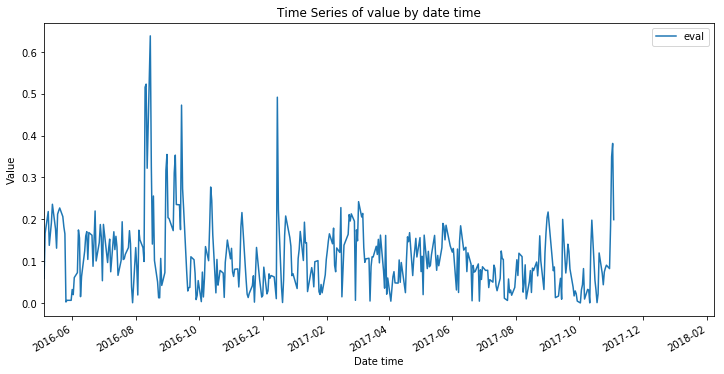

In [304]:
df2 = df.copy()
df2 = df2.loc[training_points:]
df2 = df2[['Datetime', 'scaled_value', "open", "high", "low", "close"]]
print(df2.index)

errorsDF = pd.DataFrame(errors, columns=['eval','eopen','ehigh','elow', 'eclose'])
#errorsDF = pd.DataFrame(errors, columns=['a'])
print(errorsDF.shape)
errorsDF = errorsDF[['eval']]
errorsDF['eval'] = errorsDF['eval'].abs()
#errorsDF['predval']=scaler.inverse_transform(pd.DataFrame(errorsDF['predval']))
print(errorsDF.head(5))
print(errorsDF.index)

print(df2.head(5))
print(df2.shape)

df2.reset_index(drop=True, inplace=True)
errorsDF.reset_index(drop=True, inplace=True)

dfModified = pd.concat([df2, errorsDF], axis=1)
print(dfModified.shape)
print(dfModified.head(5))
dfModified.plot(x='Datetime', y='eval', figsize=(12,6))
plt.xlabel('Date time')
plt.ylabel('Value')
plt.title('Time Series of value by date time')

df2 = dfModified[(dfModified.Datetime >= '2014-11-02') & (dfModified.Datetime < '2014-11-03')]
df2 = df2.reset_index(drop=True)
print(df2.head(5))

In [305]:
y_testDF = pd.DataFrame(y_test, columns=['val','o_open','o_high','o_low','o_close'])
y_predDF = pd.DataFrame(y_pred, columns=['val','p_open','p_high','p_low','p_close'])
y_testDF = y_testDF[['val']]
y_predDF = y_predDF[['val']]
#y_testDF['origval']=scaler.inverse_transform(pd.DataFrame(y_testDF['origval']))
#y_predDF['predval']=scaler.inverse_transform(pd.DataFrame(y_predDF['predval']))
print(y_testDF.head(5))
print(y_predDF.head(5))

        val
0  0.295648
1  0.159879
2  0.098942
3  0.179613
4  0.151523
        val
0  0.354014
1  0.326622
2  0.317578
3  0.317402
4  0.315316


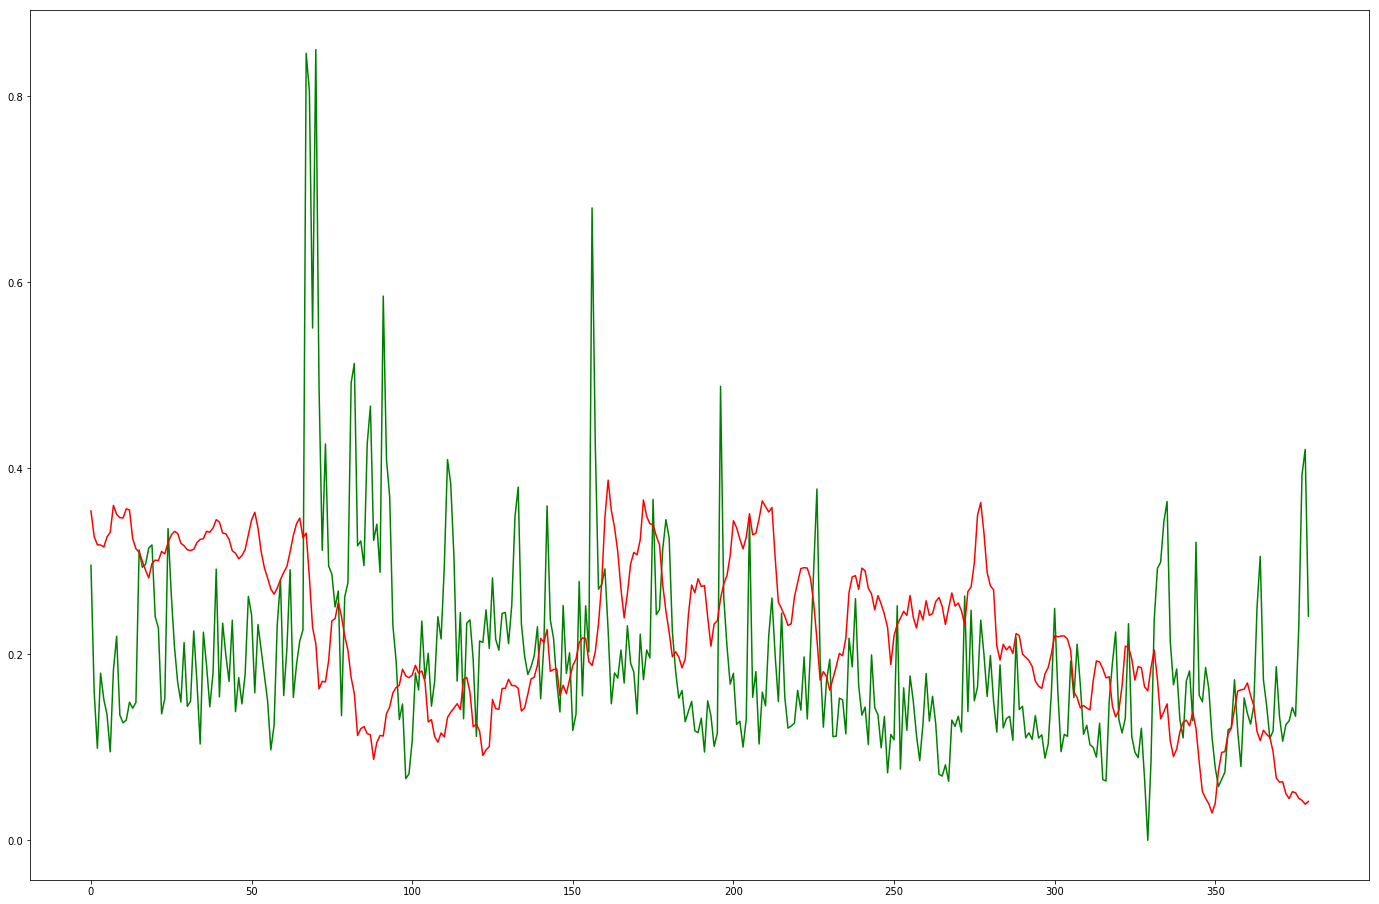

In [306]:
plt.figure(figsize=(24,16))
plt.plot(y_testDF, color='green')
plt.plot(y_predDF, color='red')

In [307]:
#based on cutoff after sorting errors
dist = np.linalg.norm(y_testDF - y_predDF, axis=-1)

scores =dist.copy()
print(scores.shape)
scores.sort()
cutoff = int(0.995 * len(scores))
print(cutoff)
print(scores[cutoff:])
threshold= scores[cutoff]


(380,)
378
[0.52311416 0.63846276]


In [308]:
#label the records anomalies or not based on threshold
z = zip(dist >= threshold, dist)

y_label=np.zeros(df.shape[0])
error = np.zeros(df.shape[0])
i=training_points+n_steps
print(i)
for idx, (is_anomaly, dist) in enumerate(z):
    if is_anomaly:
        y_label[i] = 1
    error[i] = dist
    i = i + 1
print(len(y_label))
print(len(error))

564
944
944


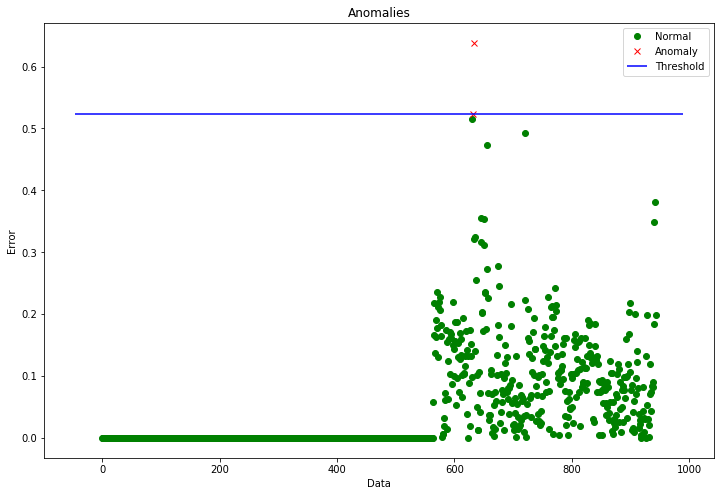

In [309]:
viz = Visualization()
viz.draw_anomaly(y_label, error, threshold)

In [310]:
print(df.shape)
print(len(y_label))
adf = pd.DataFrame({'Datetime': df['Datetime'], 'observation': df['scaled_value'],
                    'error': error, 'anomaly': y_label})
adf.head(5)


(944, 8)
944


,Datetime,observation,error,anomaly
0,2014-05-12,0.156303,0.0,0.0
1,2014-05-13,0.122488,0.0,0.0
2,2014-05-14,0.105756,0.0,0.0
3,2014-05-15,0.249212,0.0,0.0
4,2014-05-16,0.183481,0.0,0.0


Text(0.5,1,'Time Series of value by date time')

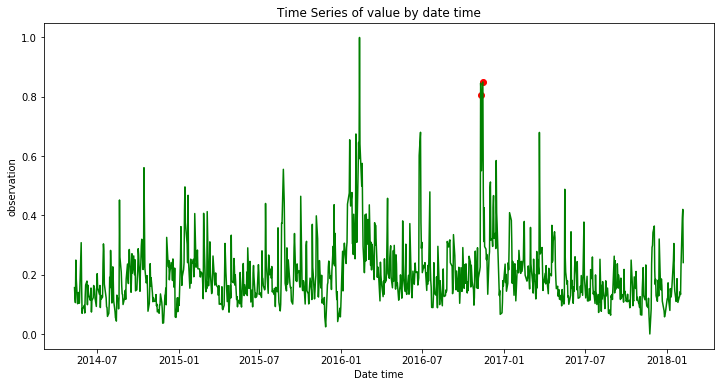

In [311]:
figure, axes = plt.subplots(figsize=(12, 6))
axes.plot(adf['Datetime'], adf['observation'], color='g')
anomaliesDF = adf.query('anomaly == 1')
axes.scatter(anomaliesDF['Datetime'].values, anomaliesDF['observation'], color='r')
plt.xlabel('Date time')
plt.ylabel('observation')
plt.title('Time Series of value by date time')